# Logistic Regression Assumptions

- When the assumptions of logistic regression analysis are not met, problems such as biased coefficient estimates or very large standard errors for the logistic regression coefficients may lead to invalid statistical inferences. 
- In this demo, we go through each key assumption with code examples (on the Titanic dataset)
- Link to TowardsDataScience article: *Coming soon*

### References
- https://www.reneshbedre.com/blog/logistic-regression.html#odds-and-odds-ratio-or
- https://www.statisticssolutions.com/free-resources/directory-of-statistical-analyses/assumptions-of-logistic-regression/
- http://www.sthda.com/english/articles/36-classification-methods-essentials/148-logistic-regression-assumptions-and-diagnostics-in-r/
- https://www.statology.org/assumptions-of-logistic-regression/
- https://dhirajkumarblog.medium.com/top-5-assumptions-for-logistic-regression-96b11d24d357
- www.lexjansen.com/wuss/2018/130_Final_Paper_PDF.pdf
- https://www.statisticssolutions.com/free-resources/directory-of-statistical-analyses/what-is-logistic-regression/
- https://datamahadev.com/assumptions-of-logistic-regression/
- https://www.youtube.com/watch?v=sciPFNcYqi8&ab_channel=MikeCrowson
- https://www.researchgate.net/publication/344138306_Logistic_Regression_Using_SPSS
- http://www.statisticssolutions.com/wp-content/uploads/wp-post-to-pdf-enhanced-cache/1/assumptions-of-logistic-regression.pdf
- https://www.datasklr.com/ols-least-squares-regression/diagnostics-for-leverage-and-influence
- https://www.statisticshowto.com/cooks-distance/
- https://online.stat.psu.edu/stat462/node/173/
- https://www.statsmodels.org/stable/examples/notebooks/generated/discrete_choice_example.html?highlight=logit#Plot-fitted-values-vs-Pearson-residuals
- https://bookdown.org/egarpor/PM-UC3M/glm-diagnostics.html#glm-diagnostics-3
- https://bookdown.org/jefftemplewebb/IS-6489/logistic-regression.html#fn40

### Contents
[**Initial Setup**](#initial-setup)

[**Assumption 1** - Appropriate outcome type](#assumption-outcome) 

[**Assumption 2** - Linearity of independent variables and log odds](#assumption-linearity) 

[**Assumption 3** - No strongly influential outliers](#assumption-outlier)  

[**Assumption 4** - Absence of multicollinearity](#assumption-multicollinearity)  

[**Assumption 5** - Independence of observations](#assumption-independence)  

[**Assumption 6** - Sufficiently large sample size](#assumption-size)  

___

<a name='initial-setup'></a>
### Initial Setup
- Import and pre-process Titanic dataset (suitable example as it is a classification problem)
- Can ignore the details of this segment, as the objective here is just to prepare a dataset for the subsequent assumptions testing
- Reference: https://www.kaggle.com/mnassrib/titanic-logistic-regression-with-python

In [1]:
# Import dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plot
import seaborn as sns
import math
from sklearn.linear_model import LogisticRegression

import statsmodels.api as sm
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod import families
from statsmodels.stats.outliers_influence import variance_inflation_factor

#### Basic pre-processing

In [2]:
# Import Titanic dataset (train.csv)
df_raw = pd.read_csv('data/train.csv')

# Create categorical variable for traveling alone
df_raw['TravelAlone'] = np.where((df_raw["SibSp"] + df_raw["Parch"])>0, 0, 1).astype('uint8')
df_raw.drop('SibSp', axis=1, inplace=True)
df_raw.drop('Parch', axis=1, inplace=True)
df_raw.drop('PassengerId', axis=1, inplace=True)
df_raw.drop('Name', axis=1, inplace=True)
df_raw.drop('Ticket', axis=1, inplace=True)
df_raw.drop('Cabin', axis=1, inplace=True)
df_raw.drop('Fare', axis=1, inplace=True)

# Create categorical variables and drop some variables
df_titanic = pd.get_dummies(df_raw, columns=["Pclass","Embarked","Sex"], 
                         drop_first=True) # Remove first variable to prevent collinearity

# Fill NaN (median imputation)
df_titanic["Age"].fillna(df_titanic["Age"].median(skipna=True), inplace=True)

df_titanic.head()

,Survived,Age,TravelAlone,Pclass_2,Pclass_3,Embarked_Q,Embarked_S,Sex_male
0,0,22.0,0,0,1,0,1,1
1,1,38.0,0,0,0,0,0,0
2,1,26.0,1,0,1,0,1,0
3,1,35.0,0,0,0,0,1,0
4,0,35.0,1,0,1,0,1,1


In [3]:
# Defining dependent and independent variables
X_cols = df_titanic.columns.to_list()[1:]
X = df_titanic[X_cols]
y = df_titanic['Survived']

___
<a name='assumption-outcome'></a>
### Assumption 1 - Appropriate outcome type

In [26]:
print(df_titanic['Survived'].nunique())

2


In [5]:
df_titanic['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

- There are only two outcomes (i.e. binary classification of survived or did not survive), so we will be using Binary Logistic Regression (which is the default method we use when we specify family=Binomial in our logit models earlier)
- Other types of Logistic Regression (where outcomes > 2) include:
    - Multinomial Logistic Regression: Target variable has three or more nominal categories such as predicting the type of Wine
    - Ordinal Logistic Regression: Target variable has three or more ordinal categories such as restaurant or product rating from 1 to 5.
- More info: https://www.datacamp.com/community/tutorials/understanding-logistic-regression-python

___
<a name='assumption-linearity'></a>
### Assumption 2 - Linearity of independent variables and log odds

- One of the important assumptions of logistic regression is the linearity of the logit over the continuous covariates. This assumption means that relationships between the continuous predictors and the logit (log odds) is linear. 
- The **Box-Tidwell transformation (test)** can be used to test the linearity in the logit assumption when performing logistic regression.
- It checks whether the logit transform is a linear function of the predictor, effectively adding the non-linear transform of the original predictor as an interaction term to test if this addition made no better prediction.
- A **statistically significant** p-value of the interaction term in the Box-Tidwell transformation means that the linearity assumption is violated
- If one variable is indeed found to be non-linear, then we can resolve it by incorporating higher order polynomial terms for that variable in the regression analysis to capture the non-linearity (e.g. x^2)
- Another solution to this problem is the categorization of the independent variables.  That is transforming metric variables to ordinal level and then including them in the model. 

___
- Details on R implementation of Box-Tidwell test in R, please refer to the `Box-Tidwell-Test-in-R.ipynb` notebook
- There is no native Python package to run the Box Tidwell test (unlike in R), so we will be coding the test below manually

In [6]:
# Box Tidwell only works for positive values. Hence, drop values where x = 0
df_titanic = df_titanic.drop(df_titanic[df_titanic.Age == 0].index)

# Export processed df_titanic for separate R notebook: `Box-Tidwell-Test-in-R.ipynb`
# df_titanic_2.to_csv('data/train_processed.csv', index=False)

#### Logistic Regression with statsmodel
- Inclusion of interaction term (logit transform) as part of Box-Tidwell test

In [27]:
df_titanic_lt = df_titanic.copy()

# Add logit transform interaction term for age i.e. Age * Log(Age)
df_titanic_lt['Age:Log_Age'] = df_titanic_lt['Age'].apply(lambda x: x * np.log(x))
df_titanic_lt.head()

,Survived,Age,TravelAlone,Pclass_2,Pclass_3,Embarked_Q,Embarked_S,Sex_male,Age:Log_Age
0,0,22.0,0,0,1,0,1,1,68.002934
1,1,38.0,0,0,0,0,0,0,138.228274
2,1,26.0,1,0,1,0,1,0,84.710510
3,1,35.0,0,0,0,0,1,0,124.437182
4,0,35.0,1,0,1,0,1,1,124.437182


In [30]:
# Redefining independent variables to include interaction terms
X_lt_cols = df_titanic_lt.columns.to_list()[1:]
X_lt = df_titanic_lt[X_lt_cols]
  
# Building model and fit the data (using statsmodel's Logit)
logit_model = GLM(y, X_lt, family=families.Binomial())
logit_results = logit_model.fit()

# Display summary results
print(logit_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               Survived   No. Observations:                  891
Model:                            GLM   Df Residuals:                      883
Model Family:                Binomial   Df Model:                            7
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -438.05
Date:                Sat, 02 Oct 2021   Deviance:                       876.10
Time:                        00:30:31   Pearson chi2:                 1.01e+03
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Age             0.2976      0.045      6.546      

- We are interested in the p-value for the logit transform interaction term `Age:Log_Age`
- From the summary table above, we can see that the p value for `Age:Log_Age` is <0.001, which is statistically significant
- This means that there is non-linearity in the Age feature, and the assumption has been violated
- We can resolve this by including a polynomial term (e.g. Age^2) to account for the non-linearity

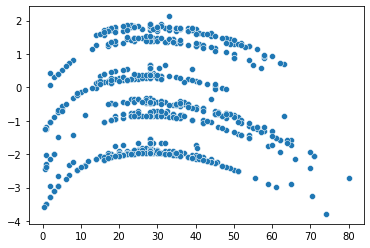

In [31]:
# Visualizing the non-linearity
predicted = logit_results.predict(X_lt)
log_odds = np.log(predicted / (1 - predicted))
sns.scatterplot(y = log_odds, x = df_titanic_lt['Age'].values);

___
<a name='assumption-outlier'></a>
### Assumption 3 - No strongly influential outliers
- Influential values are extreme individual data points that can alter the quality of the logistic regression model.
- Cook’s Distance is an estimate of the influence of a data point. It takes into account both the leverage and residual of each observation. Cook’s Distance is a summary of how much a regression model changes when the **i**th observation is removed.
- A general rule of thumb is that any observation with a Cook’s distance greater than 4/n (where n = total observations) is considered to be influential (https://www.statology.org/cooks-distance-python/ and https://www.scikit-yb.org/en/latest/api/regressor/influence.html?highlight=cook#module-yellowbrick.regressor.influence), though there are even more generic cutoff values of >0.5-1.0.
- For outliers, we can use the absolute standardized residuals to classify outliers
- Reference: https://www.statsmodels.org/dev/examples/notebooks/generated/influence_glm_logit.html

In [32]:
# Use GLM method for logreg here so that we can retrieve the influence measures
logit_model = GLM(y, X, family=families.Binomial())
logit_results = logit_model.fit()

print(logit_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               Survived   No. Observations:                  891
Model:                            GLM   Df Residuals:                      884
Model Family:                Binomial   Df Model:                            6
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -459.66
Date:                Sat, 02 Oct 2021   Deviance:                       919.33
Time:                        00:42:38   Pearson chi2:                     969.
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Age             0.0215      0.005      4.443      

In [50]:
# Get influence measures
influence = logit_results.get_influence()

# Obtain summary df of influence measures
summ_df = influence.summary_frame()

# Filter summary df to Cook distance
diagnosis_df = summ_df[['cooks_d']]

# Append absolute standardized residual values
diagnosis_df['std_resid'] = stats.zscore(logit_results.resid_pearson)
diagnosis_df['std_resid'] = diagnosis_df['std_resid'].apply(lambda x: np.abs(x))

# Sort by Cook's Distance
diagnosis_df.sort_values("cooks_d", ascending=False)
diagnosis_df

<IPython.core.display.Javascript object>

<ipython-input-50-ae33b7aee285>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diagnosis_df['std_resid'] = stats.zscore(logit_results.resid_pearson)
<ipython-input-50-ae33b7aee285>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diagnosis_df['std_resid'] = diagnosis_df['std_resid'].apply(lambda x: np.abs(x))


,cooks_d,std_resid
0,0.000065,0.439771
1,0.000459,0.532677
2,0.001136,0.771741
3,0.000381,0.450760
4,0.000070,0.513189
...,...,...
886,0.000411,0.704008
887,0.000692,0.516336
888,0.001356,1.124234
889,0.003287,1.866205


In [51]:
# Set Cook's distance threshold
cook_threshold = 4 / len(df_titanic)
print(f"Threshold for Cook Distance = {cook_threshold}")

Threshold for Cook Distance = 0.004489337822671156


<IPython.core.display.Javascript object>

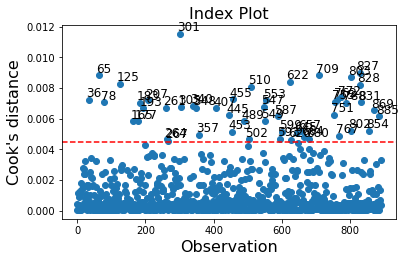

In [52]:
# Plot influence measures (Cook's distance)
fig = influence.plot_index(y_var="cooks", threshold=cook_threshold)
plt.axhline(y = cook_threshold, ls="--", color='red')
fig.tight_layout(pad=2)

In [53]:
# Find number of observations that exceed Cook's distance threshold
outliers = diagnosis_df[diagnosis_df['cooks_d'] > cook_threshold]
prop_outliers = round(100*(len(outliers) / len(df_titanic)),1)
print(f'Proportion of data points that are highly influential = {prop_outliers}%')

Proportion of data points that are highly influential = 5.7%


In [54]:
# Find number of observations which are BOTH outlier (std dev > 3) and highly influential
extreme = diagnosis_df[(diagnosis_df['cooks_d'] > cook_threshold) & 
                       (diagnosis_df['std_resid'] > 3)]
prop_extreme = round(100*(len(extreme) / len(df_titanic)),1)
print(f'Proportion of highly influential outliers = {prop_extreme}%')

Proportion of highly influential outliers = 1.6%


In [55]:
# Display top 5 most influential outliers
extreme.sort_values("cooks_d", ascending=False).head()

,cooks_d,std_resid
65,0.008837,3.010619
709,0.008837,3.010619
803,0.008708,4.084871
622,0.008389,3.290215
125,0.008263,3.594871


In [56]:
# Deep dive into index 65 (extreme outlier)
df_titanic.iloc[65]

Survived        1.0
Age            28.0
TravelAlone     0.0
Pclass_2        0.0
Pclass_3        1.0
Embarked_Q      0.0
Embarked_S      0.0
Sex_male        1.0
Name: 65, dtype: float64

- It is important to note that for data points with relative high Cook's distances, it does **not** automatically mean that it should be immediately removed from the dataset. It is essentially an indicator to highlight which data points are worth looking deeper into, to understand whether they are true anomalies or not
- In practice, an assessment of “large” values is a judgement call based on experience and the particular set of data being analyzed.
- In addition, based on our pre-defined threshold (4/N), only 5% (51/891) of the points are in the outlier zone, which is small as well. The issue comes when there is a significant number of data points classified as outliers.
- The management of outliers is outside the scope of this demo

___
<a name='assumption-multicollinearity'></a>
### Assumption 4 - Absence of multicollinearity

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

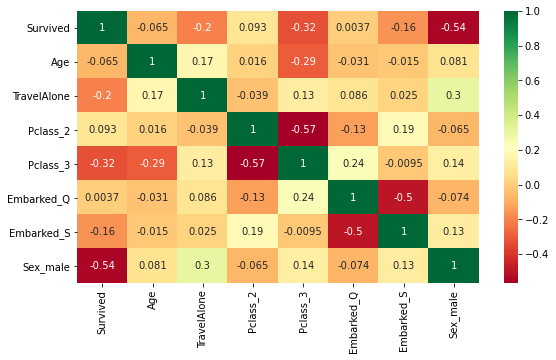

In [57]:
corrMatrix = df_titanic.corr()
plt.subplots(figsize=(9, 5))
sns.heatmap(corrMatrix, annot=True, cmap="RdYlGn")
plt.show()

- Correlation matrix can be difficult to interpret when there are many independent variables
- Furthermore, not all collinearity problems can be detected by inspection of the correlation matrix: it is possible for collinearity to exist between three or more variables even if no pair of variables has a particularly high correlation. 
- As such, we use Variance Inflation Factor (VIF) instead

#### Variance Inflation Factor (VIF)

In [58]:
# Use variance inflation factor to identify any significant multi-collinearity
def calc_vif(df):
    vif = pd.DataFrame()
    vif["variables"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return(vif)

calc_vif(df_titanic)

,variables,VIF
0,Survived,1.692870
1,Age,4.493333
2,TravelAlone,2.946677
3,Pclass_2,1.842347
4,Pclass_3,3.287706
5,Embarked_Q,1.591259
6,Embarked_S,4.766652
7,Sex_male,3.603656


- The threshold for VIF is usually 5 (i.e. values above 5 means there is presence of multicollinearity)
- Since all the variables have VIF <5,  it means that there is no multicollinearity, and this assumption is satisfied
- Let's have a look at the situation where we did **not** drop the first variable upon getting dummies:

In [19]:
# Not dropping first variables upon get_dummies
df_test = pd.get_dummies(df_raw, columns=["Pclass","Embarked","Sex"], 
                           drop_first=False)
df_test.drop('Sex_female', axis=1, inplace=True)
df_test["Age"].fillna(df_test["Age"].median(skipna=True), inplace=True)
calc_vif(df_test)

,variables,VIF
0,Survived,1.636077
1,Age,1.241910
2,TravelAlone,1.175196
3,Pclass_1,115.224082
4,Pclass_2,98.785993
5,Pclass_3,259.376346
6,Embarked_C,69.935987
7,Embarked_Q,36.788296
8,Embarked_S,91.317555
9,Sex_male,1.533996


- From the above results, we can see that there are numerous VIF values way above the threshold of 5 when we do not drop at least 1 category from the dummy categories we generated
- This is a clear sign of multicollinearity

___
<a name='assumption-independence'></a>
### Assumption 5 - Independence of observations
- Error terms need to be independent. That is that the data-points should not be from any dependent samples design, e.g., before-after measurements, or matched pairings. 

In [20]:
# Setup logistic regression model (using GLM method so that we can retrieve residuals)
logit_model = GLM(y, X, family=families.Binomial())
logit_results = logit_model.fit()
print(logit_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               Survived   No. Observations:                  891
Model:                            GLM   Df Residuals:                      884
Model Family:                Binomial   Df Model:                            6
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -459.66
Date:                Fri, 01 Oct 2021   Deviance:                       919.33
Time:                        22:51:07   Pearson chi2:                     969.
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Age             0.0215      0.005      4.443      

#### Check residuals series

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

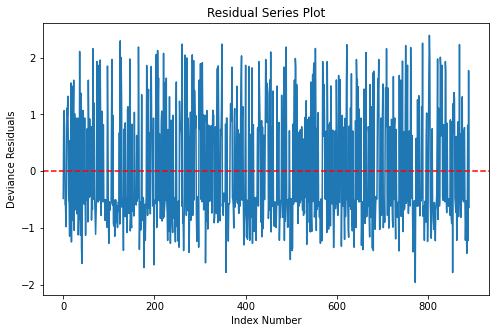

In [68]:
# Generate residual series plot
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111, title="Residual Series Plot",
    xlabel="Index Number", ylabel="Deviance Residuals")

# ax.plot(df_titanic_2.index.tolist(), stats.zscore(logit_results.resid_pearson))
ax.plot(df_titanic.index.tolist(), stats.zscore(logit_results.resid_deviance))
plt.axhline(y = 0, ls="--", color='red');

- From the above Deviance residuals versus index number plot, we can see that the assumption of independence of errors is satisfied

#### Further investigation on residual dependence plots (Optional)
- This is additional investigation. The above check on residuals series (based on index numbers) is sufficient
- Reference: https://freakonometrics.hypotheses.org/8210

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

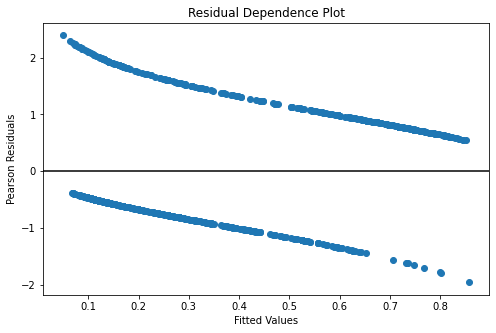

In [22]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(
    111,
    title="Residual Dependence Plot",
    xlabel="Fitted Values",
    ylabel="Pearson Residuals",
)
# ax.scatter(logit_results.mu, stats.zscore(logit_results.resid_pearson))
ax.scatter(logit_results.mu, stats.zscore(logit_results.resid_deviance))
ax.axis("tight")
ax.plot([0.0, 1.0], [0.0, 0.0], "k-");

#### Add a Locally Weighted Scatterplot Smoothing (LOWESS) line to better visualize independence

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

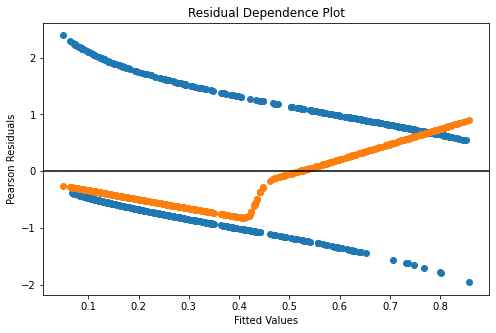

In [23]:
# Setup LOWESS function
lowess = sm.nonparametric.lowess

# Get y-values from LOWESS (set return_sorted=False)
y_hat_lowess = lowess(logit_results.resid_pearson, logit_results.mu, 
                      return_sorted = False,
                      frac=2/3)

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111,
    title="Residual Dependence Plot",
    xlabel="Fitted Values",
    ylabel="Pearson Residuals",
)
# ax.scatter(logit_results.mu, stats.zscore(logit_results.resid_pearson))
ax.scatter(logit_results.mu, stats.zscore(logit_results.resid_deviance))
ax.scatter(logit_results.mu, y_hat_lowess)
ax.axis("tight")
ax.plot([0.0, 1.0], [0.0, 0.0], "k-");

___
<a name='assumption-size'></a>
### Assumption 6 - Sufficiently large sample size

In [24]:
# Find total number of observations
len(df_titanic)

891

In [69]:
# Get value counts for independent variables (mainly focus on categorical)
for col in df_titanic.columns.to_list()[1:]:
    if df_titanic.dtypes[col] == 'uint8':
        print(df_titanic[col].value_counts())

1    537
0    354
Name: TravelAlone, dtype: int64
0    707
1    184
Name: Pclass_2, dtype: int64
1    491
0    400
Name: Pclass_3, dtype: int64
0    814
1     77
Name: Embarked_Q, dtype: int64
1    644
0    247
Name: Embarked_S, dtype: int64
1    577
0    314
Name: Sex_male, dtype: int64


- Rule of thumb is to have at least 10-20 instances of the least frequent outcome for each predictor variable in your model
- From the value counts above, we can see that this assumption is satisfied

- Another rule of thumb is to have at least 500 observations in the entire dataset
- Overall, we have 891 observations, which is a decent dataset size to work with